In [1]:
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import os.path
import graph_tool as gt
import nn2graph
import numpy as np
import pandas as pd
import statsmodels.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

#### Load data

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape((-1, X_train.shape[1] * X_train.shape[2]))
X_train = (X_train > 0).astype(np.float32)
X_test = X_test.reshape((-1, X_test.shape[1] * X_test.shape[2]))
X_test = (X_test > 0).astype(np.float32)
y_train_orig, y_test_orig = y_train, y_test
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

#### Build model

In [3]:
hidden_dims = 64
input_dims = X_train.shape[1]
input_0 = Input((input_dims,))
dense_1 = Dense(hidden_dims, activation='relu')(input_0)
dense_2 = Dense(hidden_dims, activation='relu')(dense_1)
dense_3 = Dense(hidden_dims, activation='relu')(dense_2)
dense_4 = Dense(hidden_dims, activation='relu')(dense_3)
dense_out = Dense(10, activation='softmax', kernel_initializer='he_uniform')(dense_4)
model = Model(inputs=input_0, outputs=dense_out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [4]:
load_saved_model = True
if load_saved_model and os.path.exists('data/outputs/mnist_dnn_4x64_10.h5'):
    model = load_model('data/outputs/mnist_dnn_4x64_10.h5')
else:
    model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test))
    model.save('data/outputs/mnist_dnn_4x64_10.h5')

In [5]:
print(model.evaluate(X_test, y_test, verbose=0))
y_pred = model.predict(X_test)

[2.2895871978759765, 0.0974]


In [6]:
def subsample_inds(n):
    return np.concatenate([np.random.choice(np.where(y_test_orig == c)[0], n // 10) for c in range(10)], axis=0)

#### Convert neural network to graph

In [7]:
N = 5000
rand_inds = subsample_inds(N)
g_full, g_xs = nn2graph.dense_activations_to_graph(model, X_test[rand_inds])

In [58]:
layer_sizes = [X_test.shape[-1]] + [layer.units for layer in model.layers if isinstance(layer, Dense)]
i_max = np.argmax([g.num_edges() for g in g_xs])
i_min = np.argmin([g.num_edges() for g in g_xs])
g_max = g_xs[i_max]
g_min = g_xs[i_min]
g_by_class = [[g for j, g in enumerate(g_xs) if y_test_orig[j] == i] for i in range(10)]
print('edge max label: {}'.format(y_test_orig[i_max]))
print('edge min label: {}'.format(y_test_orig[i_min]))

edge max label: 3
edge min label: 6


In [8]:
from graph_tool.inference.minimize import minimize_nested_blockmodel_dl
min_state = minimize_nested_blockmodel_dl(g_max)
print(min_state)

<NestedBlockState object, with base <BlockState object with 8 blocks (8 nonempty), degree-corrected, for graph <GraphView object, undirected, with 1050 vertices and 21624 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f84cc6eeef0, at 0x7f84cc6f22e8>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f84cc6eeef0, at 0x7f84cc6f2358>, False) at 0x7f84cc6eeef0>, at 0x7f844025a1d0>, and 3 levels of sizes [(1050, 8), (8, 2), (2, 1)] at 0x7f844024cba8>


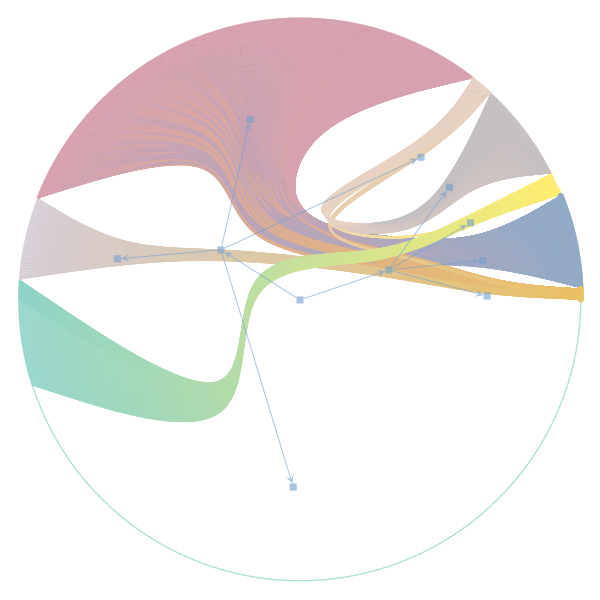

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f84cc6eeef0, at 0x7f855cb65898>,
 <Graph object, directed, with 1061 vertices and 1060 edges at 0x7f855cb26cc0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f855cb26cc0, at 0x7f855cb26588>)

In [11]:
min_state.draw()

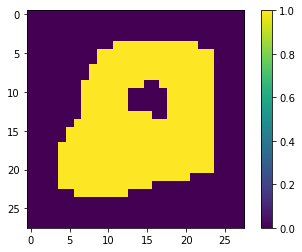

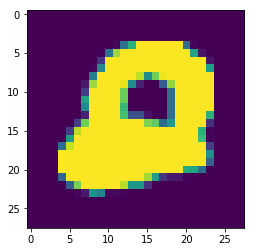

In [13]:
x = min_state.get_bs()[0]
plt.imshow(x[:784].reshape((28,28)))
plt.colorbar()
plt.show()
plt.imshow(X_test[i_max].reshape((28,28)))
plt.show()

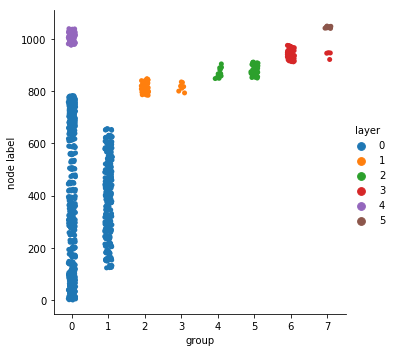

In [10]:
import pandas as pd

bs = min_state.get_bs()[0]
df = pd.DataFrame.from_dict({'group': bs, 'node label': list(range(len(bs))), 'layer': g_max.vp['layer'].a})
sns.catplot(x='group', y='node label', data=df, hue='layer')

<NestedBlockState object, with base <BlockState object with 10 blocks (10 nonempty), degree-corrected, for graph <GraphView object, undirected, with 1050 vertices and 5914 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f9c8050c898, at 0x7f9c8050cc50>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f9c8050c898, at 0x7f9c8050ccc0>, False) at 0x7f9c8050c898>, at 0x7f9d247135f8>, and 4 levels of sizes [(1050, 10), (10, 4), (4, 2), (2, 1)] at 0x7f9d24702f60>


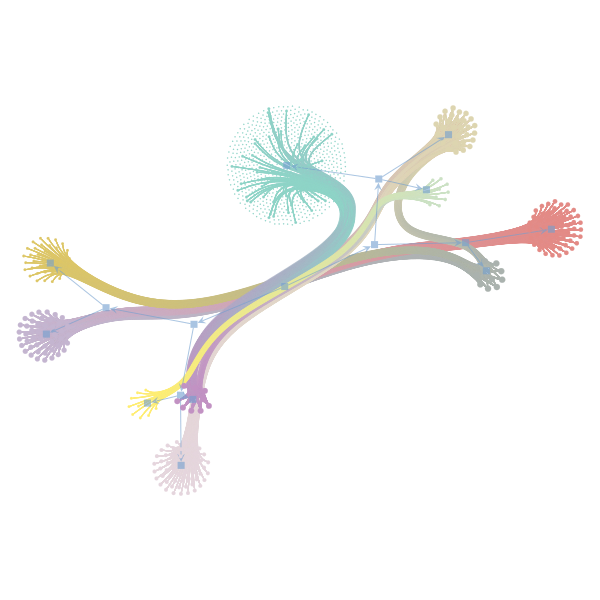

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9c8050c898, at 0x7f9d24713dd8>,
 <Graph object, directed, with 1067 vertices and 1066 edges at 0x7f9d24702ef0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9d24702ef0, at 0x7f9d247027b8>)

In [14]:
from graph_tool.inference.minimize import minimize_nested_blockmodel_dl
min_state = minimize_nested_blockmodel_dl(g_min)
print(min_state)
min_state.draw(layout='sfdp')

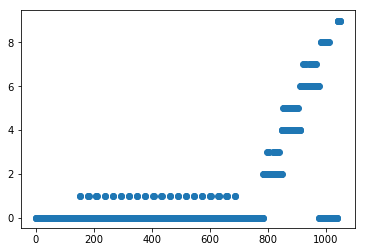

In [15]:
plt.scatter(range(g_min.num_vertices()), min_state.get_bs()[0])